# Animations for Interface Shapes

### Import Libraries and define functions

In [1]:
#Import the necessary libraries.
import numpy as np
from numpy import loadtxt
from scipy.integrate import odeint
from scipy.special import erfc
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Use LaTeX font for plots.
plt.rcParams['text.usetex'] = True

In [2]:
#Define the function for the height of the interface.
def h_an(x,t):
    # Check if t is 0
    if t==0:
        return np.ones(x.shape)
    
    else:
        xi = x/(2*np.sqrt(t))
        return np.ones(x.shape)+(2*np.sqrt(t))*(np.exp(-xi**2)/np.sqrt(np.pi) - xi*erfc(xi))

In [3]:
# Define the system of ODEs.
def semidiscODEs2(h,t, N,dx):
    
    # Compute h_0 using the boundary condition.
    if t==0:
        h0 = 1
    else:
        # Solve the cubic for h0, which contains h1 and h2.
        # used https://en.wikipedia.org/wiki/Cubic_equation#General_cubic_formula
        
        # Order 2?
        a  = -3
        b  = -2*h[0] - h[1]
        c  = 5*h[0]**2 - 2*h[0]*h[1]
        d  = 4*h[0]**3 - h[1]*(h[0]**2) + 8*dx
        D0 = b**2 - 3*a*c
        D1 = 2*b**3 - 9*a*b*c +27*d*(a**2)
        C  = np.cbrt((D1+np.sqrt(D1**2 - 4*D0**3))/2)
        h0 = -(b + C + D0/C)/(3*a)
     
    # Give h_N.
    hN = 1
    
    # Write vectors of h, one with h_0, one with h_N.
    hl = np.concatenate((np.array([h0]),h))
    hu = np.concatenate((h,np.array([hN])))
    
    # Compute the respective fluxes.
    q = (((hu+hl)/2)**3)*(hu-hl)/dx + (hu+hl)/2
    
    # Compute dh_i/dt for each i
    dh = (q[1:]-q[:-1])/dx
    
    return dh

In [4]:
# Find the value of h_0 given the end result.
def h0(h,t, dx):
    # Solve the cubic for h0, which contains h1 and h2.
    # used https://en.wikipedia.org/wiki/Cubic_equation#General_cubic_formula
    
    # Order 2?
    a  = -3
    b  = -2*h[:,0] - h[:,1]
    c  = 5*h[:,0]**2 - 2*h[:,0]*h[:,1]
    d  = 4*h[:,0]**3 - h[:,1]*(h[:,0]**2) + 8*dx
    D0 = b**2 - 3*a*c
    D1 = 2*b**3 - 9*a*b*c + 27*d*(a**2)
    C  = np.cbrt((D1+np.sqrt(D1**2 - 4*D0**3))/2)
    h0 = -(b + C + D0/C)/(3*a)
    
    h0[0] = 1
    
    return np.array([h0]).T

### Solve Numerically

In [5]:
# Define the parameters of the system, the time array, and the space grid.
N = 2**8
XN = 2
dx = XN/N
t = np.arange(0,0.0401,0.0001)
y_init0 = np.zeros(N-1)
y_init1 = np.ones(N-1)
x = np.linspace(0,XN,N+1)

#Set up a meshgrid of x and t for the analytical solution.
x2, t2 = np.meshgrid(x, t)

In [6]:
# Solve the IVP. # Uses faster version
y2 = odeint(semidiscODEs2, y_init1, t, args=(N,dx))

# Use the boundary value to find the value at x_N
yN2 = np.array([np.ones(len(t))]).T

# Glue x_0, x_N parts to the rest of the solution.
y_num2 = np.concatenate((h0(y2,t2,dx),y2,yN2), axis=1)

### Parameters

We need these due to the different nondimensionalisations used so that we can translate from one to another.

In [7]:
# Dimensional Parameters.
rho = 1440
mu = 10
U = 0.01
H = 0.03
g = 9.81
X = (rho*g*H**3)/(3*mu*U)
T = X/U

# DNS Dimensional Parameters.
T2 = H/U

### Make the animation for each of No Slip and Free Slip

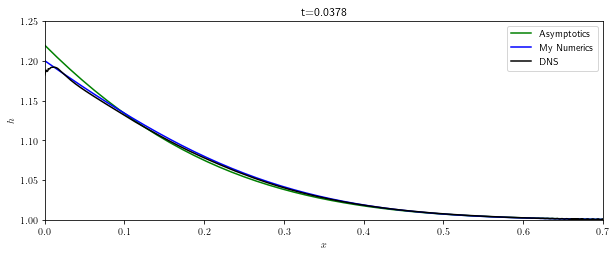

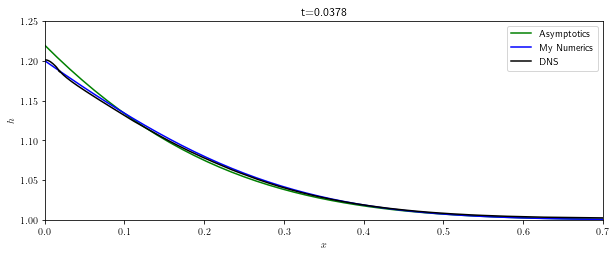

In [8]:
for slip in ("No", "Free"):

    # Initialise the plot.
    fig, ax = plt.subplots()

    # Set up the initial frame by extracting the data from the .dat file and splitting it up.
    data = loadtxt('DNS '+slip+' Slip/interfacesLiquid-0.00.dat')

    datax = data[::2,0]*(H/X)
    datah = data[::2,1]

    # Plot each side of the drop and the centre of mass.
    line3, = ax. plot(x, h_an(x,0), color='green', label=r'Asymptotics')
    line2, = ax.plot(x, y_num2[0,:], color='blue', label=r'My Numerics')
    line1, = ax.plot( datax, datah, color='black', label=r'DNS')

    # Set up each frame to be plotted.
    def animate(i):

        # Find the right time for the file name. 
        j = str(np.round(i*0.01,2))    
        while len(j)<4:
            j = j+str(0)

        # Extract the data from the .dat file and split into two arrays.
        newdata = loadtxt('DNS '+slip+' Slip/interfacesLiquid-'+j+'.dat')

        newdatax = newdata[::2,0]*(H/X)
        newdatah = newdata[::2,1]

        # Update the DNS.
        line1.set_xdata(newdatax)
        line1.set_ydata(newdatah)

        # Find the time we are evaluating at to 4dp.
        ti = np.round(i*0.01*(H/X),4)
        t_index = int(np.round(ti/0.0001,0))

        # Update the Numerics.
        line2.set_xdata(x)
        line2.set_ydata(y_num2[t_index,:])

        # Update the Asymptotics.
        line3.set_xdata(x)
        line3.set_ydata(h_an(x,ti))

        # Make sure the time is the right format for the title.
        tj = str(ti)
        while len(tj)<6:
            tj = tj+str(0)

        # Title giving the frame the time
        ax.set_title(r"t=s1".replace('s1',tj))
        return line3, line2, line1,


    #Add details and set the figure shape/size.
    fig.set_size_inches(10,5)
    #ax.axis('equal')
    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(axis='both', which='major')

    ax.set_xlim(0,0.7)
    ax.set_xlabel(r'$x$')

    ax.set_ylim(1,1.25)
    ax.set_ylabel(r'$h$')

    ax.legend()

    #Make the animation. Number of frames is to go to the final t value from DNS.
    ani = animation.FuncAnimation(fig, animate, interval=2000, frames=161, blit=True, save_count=161)

    #Save the figure as a gif. Low fps is used to slow it down.
    writergif = animation.PillowWriter(fps=10)
    ani.save('interface_shape_'+slip+'_Slip.gif',writer=writergif, dpi=250)

    plt.show()

We also make an animation for the difference with the DNS data.

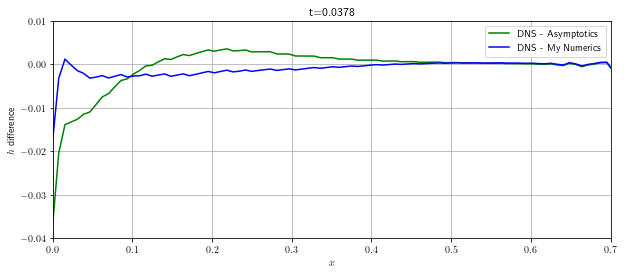

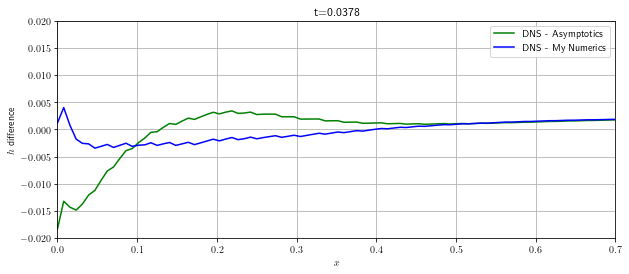

In [9]:
for slip in ("No", "Free"):

    # Initialise the plot.
    fig, ax = plt.subplots(figsize=(10,4))

    # Set up the initial frame by extracting the data from the .dat file and splitting it up.
    data = loadtxt('DNS '+slip+' Slip/interfacesLiquid-0.00.dat')

    datax = data[::2,0]*(H/X)
    datah = data[::2,1]

    # Find the right index to compare the DNS with.
    ee = x.reshape(1,-1)
    ff = datax.reshape(-1,1)
    diffs = np.abs(ee-ff)
    args = diffs.argmin(axis=0)

    # Plot setup.
    line3, = ax.plot(x, datah[args]-h_an(x,0), color='green', label=r'DNS - Asymptotics')
    line2, = ax.plot(x, datah[args]-y_num2[0,:], color='blue', label=r'DNS - My Numerics')

    # Set up each frame to be plotted.
    def animate(i):

        # Find the right time for the file name. 
        j = str(np.round(i*0.01,2))    
        while len(j)<4:
            j = j+str(0)

        # Extract the data from the .dat file and split into two arrays.
        newdata = loadtxt('DNS '+slip+' Slip/interfacesLiquid-'+j+'.dat')

        newdatax = newdata[::2,0]*(H/X)
        newdatah = newdata[::2,1]

        # Find the right index to compare the DNS with.
        ff = newdatax.reshape(-1,1)
        diffs = np.abs(ee-ff)
        args = diffs.argmin(axis=0)

        # Find the time we are evaluating at to 4dp.
        ti = np.round(i*0.01*(H/X),4)
        t_index = int(np.round(ti/0.0001,0))

        # Update the Numerics.
        line2.set_xdata(x)
        line2.set_ydata(newdatah[args]-y_num2[t_index,:])

        # Update the Asymptotics.
        line3.set_xdata(x)
        line3.set_ydata(newdatah[args]-h_an(x,ti))

        # Make sure the time is the right format for the title.
        tj = str(ti)
        while len(tj)<6:
            tj = tj+str(0)

        # Title giving the frame the time
        ax.set_title(r"t=s1".replace('s1',tj))
        return line3, line2,


    #Add details and set the figure shape/size.
    ax.tick_params(axis='both', which='major')

    ax.set_xlim(0,0.7)
    ax.set_xlabel(r'$x$')
    
    if slip=="No":
        ax.set_ylim(-0.04,0.01)
    else:
        ax.set_ylim(-0.02,0.02)
    ax.set_ylabel(r'$h$ difference')

    ax.legend()
    ax.grid()

    #Make the animation. Number of frames is to go to the final t value from DNS.
    ani = animation.FuncAnimation(fig, animate, interval=2000, frames=161, blit=True, save_count=161)

    #Save the figure as a gif. Low fps is used to slow it down.
    writergif = animation.PillowWriter(fps=10)
    ani.save('interface_shape_'+slip+'_Slip_Differences.gif',writer=writergif, dpi=250)

    plt.show()